In [1]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from skimage.metrics import structural_similarity as ssim
import pickle
from PIL import Image
import cv2

%matplotlib inline

c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CONVLSTM

In [2]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []

        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor):
        b, seq_len, _, h, w = input_tensor.size()
        hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :], 
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

class WildfirePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers):
        super(WildfirePredictor, self).__init__()
        self.convLstm = ConvLSTM(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, num_layers=num_layers, return_all_layers=False)
        self.conv = nn.Conv2d(hidden_dim[-1], 1, kernel_size=1, padding=0)
        
    def forward(self, x):
        layer_output_list, last_state_list = self.convLstm(x)
        out = layer_output_list[0][:, -1, :, :, :]
        out = self.conv(out)
        
        return out

# CNN

In [3]:
class Wildfire_CNN(nn.Module):
    def __init__(self):
        super(Wildfire_CNN, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout with a 50% drop probability
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

## DIFFUSION - Classifier free guidance and Image conditioned

In [4]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def sigmoid_beta_schedule(timesteps):
    betas = torch.linspace(-6, 6, timesteps)
    betas = torch.sigmoid(betas) / (betas.max() - betas.min()) * (0.02 - betas.min()) / 10
    return betas

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def timestep_embedding(timesteps, dim, max_period=1000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """
    def forward(self, x, t_emb, c_emb, mask):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb, c_emb, mask)
            else:
                x = layer(x)
            return x

def norm_layer(channels):
    return nn.GroupNorm(32, channels)

class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, cond_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )
        
        self.cond_conv = nn.Sequential(
            nn.Conv2d(cond_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU()
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, t, cond_img, mask):
        h = self.conv1(x)
        emb_t = self.time_emb(t)
        emb_cond = self.cond_conv(cond_img) * mask[:, None, None, None]
        h += (emb_t[:, :, None, None] + emb_cond)
        h = self.conv2(h)
        
        return h + self.shortcut(x)
    
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0
        
        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)
        
    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B *  self.num_heads, -1, H * W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x
    
class UpSample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

class DownSample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, padding=1, stride=2)
        else:
            self.op = nn.AvgPool2d(stride=2)
    
    def forward(self, x):
        return self.op(x)
    
class Unet(nn.Module):
    def __init__(self, 
                 in_channels=2,
                 cond_channels=1,
                 model_channels=128,
                 out_channels=2,
                 num_res_blocks=2, 
                 attention_resolutions=(8, 16),
                 dropout=0,
                 channel_mult=(1, 2, 2, 2),
                 conv_resample=True,
                 num_heads=4):
        super().__init__()
        self.in_channels = in_channels
        self.cond_channels = cond_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions,
        self.dropout = dropout
        self.channel_mult = channel_mult,
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_emb_dim = model_channels * 4
        self.time_emb = nn.Sequential(
            nn.Linear(model_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_channels = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResidualBlock(ch, model_channels * mult, time_emb_dim, cond_channels, dropout)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_channels.append(ch)
            if level != len(channel_mult) - 1:
                self.down_blocks.append(TimestepEmbedSequential(DownSample(ch, conv_resample)))
                down_block_channels.append(ch)
                ds *= 2
        
        # middle blocks
        self.middle_blocks = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_emb_dim, cond_channels, dropout),
            AttentionBlock(ch, num_heads),
            ResidualBlock(ch, ch, time_emb_dim, cond_channels, dropout)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in enumerate(channel_mult[::-1]):
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(ch + down_block_channels.pop(), model_channels * mult, time_emb_dim, cond_channels, dropout)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))
                if level != len(channel_mult) - 1 and i == num_res_blocks:
                    layers.append(UpSample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))
                
        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(ch, out_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x, timesteps, cond_img, mask):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param cond_img: a [N x cond_C x H x W] Tensor of conditional images.
        :param mask: a 1-D batch of conditioned/unconditioned.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        t_emb = self.time_emb(timestep_embedding(timesteps, dim=self.model_channels))
        
        # down step
        h = x
        for module in self.down_blocks:
            if cond_img.shape[2:] != h.shape[2:]:
                cond_img = F.interpolate(cond_img, size=h.shape[2:], mode='nearest')
            h = module(h, t_emb, cond_img, mask)
            hs.append(h)
        # mid stage
        if cond_img.shape[2:] != h.shape[2:]:
            cond_img = F.interpolate(cond_img, size=h.shape[2:], mode='nearest')
        h = self.middle_blocks(h, t_emb, cond_img, mask)
        
        # up stage
        for module in self.up_blocks:
            h_skip = hs.pop()
            
            if h.shape[2:] != h_skip.shape[2:]:
                h = F.interpolate(h, size=h_skip.shape[2:], mode='nearest')

            if cond_img.shape[2:] != h.shape[2:]:
                cond_img = F.interpolate(cond_img, size=h.shape[2:], mode='nearest')

            cat_in = torch.cat([h, h_skip], dim=1)
            h = module(cat_in, t_emb, cond_img, mask)
        
        return self.out(h)

In [5]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear',
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        elif beta_schedule == 'sigmoid':
            betas = sigmoid_beta_schedule(timesteps)
        else:
            raise ValueError(f'Unknown beta schedule {beta_schedule}')
        
        self.betas = betas
        
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)
        )
    
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion : q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        
        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # mean and variance of q(x_t | x_0)
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    
    # mean and variance of diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: reverse of q_sample
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    # compute predicted mean and variance of p(x_{t-1} | x_t) 
    def p_mean_variance(self, model, x_t, t, cond_img, w, clip_denoised=True):
        device = next(model.parameters()).device
        batch_size = x_t.shape[0]
        
        # noise prediction from model
        pred_noise_cond = model(x_t, t, cond_img, torch.ones(batch_size).int().to(device))
        pred_noise_uncond = model(x_t, t, cond_img, torch.zeros(batch_size).int().to(device))
        pred_noise = (1 + w) * pred_noise_cond - w * pred_noise_uncond
        
        # get predicted x_0
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior_mean_variance(x_recon, x_t, t)
        
        return model_mean, posterior_variance, posterior_log_variance
    
    # denoise step: sample x_{t-1} from x_t and pred noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, cond_img, w, clip_denoised=True):
        # pred mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t, cond_img, w, clip_denoised=clip_denoised)
        
        noise = torch.randn_like(x_t)
        # no noise when t = 0 
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    
    # denoise : reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape, cond_img, w=2, clip_denoised=True):
        batch_size = shape[0]
        device = next(model.parameters()).device
        
        # start from pure noise
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long), cond_img, w, clip_denoised)
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad
    def sample(self, model, image_size, cond_img, batch_size=8, channels=3, w=2, clip_denoised=True):
        return self.p_sample_loop(model, (batch_size, channels, image_size, image_size), cond_img, w, clip_denoised)
    
    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        cond_img,
        batch_size=8,
        channels=3,
        ddim_timesteps=50,
        w=2,
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):
        
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
        
        device = next(model.parameters()).device
        
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        seq_img = [sample_img.cpu().numpy()]   
        
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)
            
            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)
    
            # 2. predict noise using model
            pred_noise_cond = model(sample_img, t, cond_img, torch.ones(batch_size).int().cuda())
            pred_noise_uncond = model(sample_img, t, cond_img, torch.zeros(batch_size).int().cuda())
            pred_noise = (1+w)*pred_noise_cond - w*pred_noise_uncond
            
            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)
            
            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))
            
            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise
            
            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev

        return sample_img.cpu().numpy()
    
    # compute train losses
    def train_losses(self, model, x_start, t, cond_img, mask_c):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t, cond_img, mask_c)
        loss = F.mse_loss(noise, predicted_noise)
        return loss 

## EVALUATION - COMPARE DIFFUSION PERFORMANCE TO BASELINE CONVLSTM

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# baseline_model = WildfirePredictor(input_dim=1, hidden_dim=[64, 64, 64], kernel_size=[3, 3, 3], num_layers=3)
# baseline_model.load_state_dict(torch.load("C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/baseline_seq_convlstm_64x64.pt"))
# baseline_model.to(device)

baseline_model = Wildfire_CNN()
baseline_model.load_state_dict(torch.load("C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/baseline_cnn_64x64_simData.pt"))
baseline_model.to(device)

diffusion_model = torch.load('C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/gde_ensemble_model_4_64x64_simData.h5')
diffusion_model.to(device)

diffusion_model_reg = torch.load('C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/results/ckpts/gde_ensemble_model_4_64x64_simData_regGuided_noDataAug.h5')
diffusion_model_reg.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')

#### Evaluation Dataset

In [7]:
class CondSeqImageDataset(Dataset):
    def __init__(self, data_dir, transform=None, conditional_offset=5):
        self.data_dir = data_dir
        self.transform = transform
        self.conditional_offset = conditional_offset
        self.cond_images = []
        self.target_images = []
        self._load_data()

    def _load_data(self):
        files = sorted([os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.endswith('.mpy')])
        for file in files:
            with open(file, 'rb') as f:
                images = pickle.load(f)
                if isinstance(images, list):
                    images = np.array(images)
                    
                for img_idx in range(len(images) - self.conditional_offset):
                    self.cond_images.append(images[img_idx])
                    self.target_images.append(images[img_idx + self.conditional_offset])

    def __len__(self):
        return len(self.cond_images)

    def __getitem__(self, idx):
        # collection_idx, image_idx = self._get_indices(idx)
        cond_image = self.cond_images[idx]
        image = self.target_images[idx]

        if self.transform:
            image = self.transform(image)
            cond_image = self.transform(cond_image)

        return image, cond_image


transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)), 
    transforms.Resize(64)
])

dataset_2 = CondSeqImageDataset("C:/Users/Anirbit/Desktop/MSc/Ind Project/Msc-Project/data/simulated_bin_frames", transform=transform)



# Split dataset into training and testing
train_size = int(0.8 * len(dataset_2))
test_size = len(dataset_2) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_2, [train_size, test_size])

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


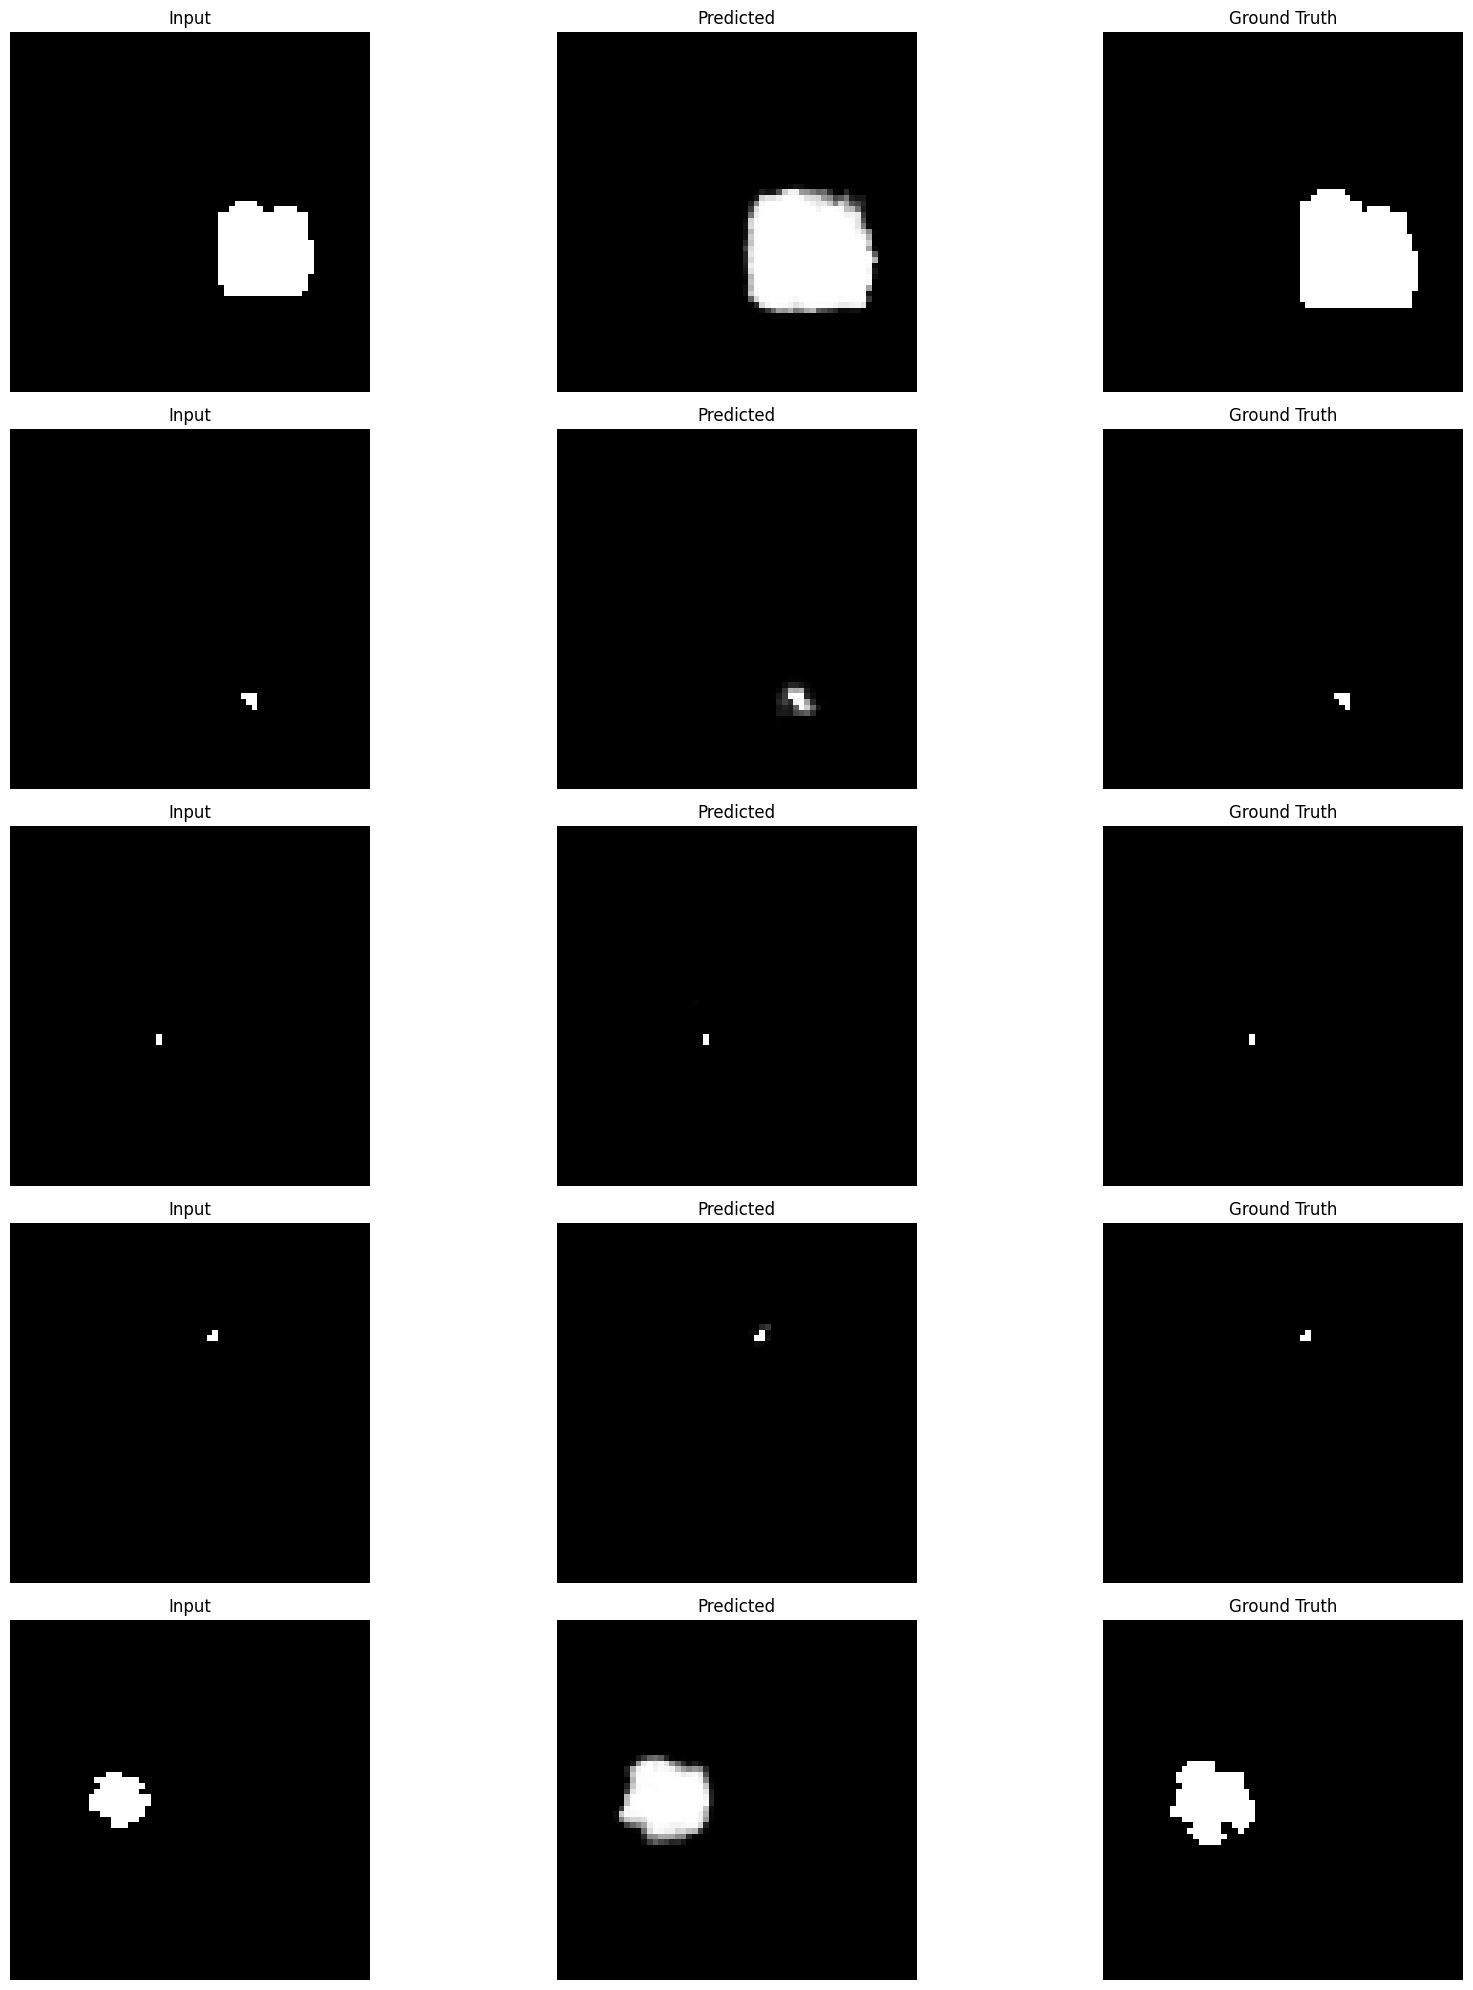

In [8]:
def generate_convlstm_predictions(model, cond_images, target_images):
    model.eval()
    predictions = []
    ground_truths = []
    inputs = []

    with torch.no_grad():
        output = model(cond_images)
        predictions.append(output.cpu())
        ground_truths.append(target_images.cpu())
        inputs.append(cond_images.cpu())

    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)
    inputs = torch.cat(inputs, dim=0)

    return predictions, ground_truths, inputs

def generate_cnn_predictions(model, cond_images, target_images):
    model.eval()
    predictions = []
    ground_truths = []
    inputs = []

    with torch.no_grad():
        output = model(cond_images)
        predictions.append(output.cpu())
        ground_truths.append(target_images.cpu())
        inputs.append(cond_images.cpu())

    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)
    inputs = torch.cat(inputs, dim=0)

    return predictions, ground_truths, inputs

def plot_cnn_predictions(predictions, ground_truths, inputs, num_images=5, save=False):
    fig, axs = plt.subplots(num_images, 3, figsize=(18, 20))
    for i in range(num_images):
        input_img = inputs[i].squeeze(0)
        axs[i, 0].imshow(input_img, cmap='gray')
        axs[i, 0].set_title(f'Input')
        axs[i, 0].axis('off')

        # Plot the predicted image
        pred_img = predictions[i].squeeze(0)
        axs[i, 1].imshow(pred_img, cmap='gray')
        axs[i, 1].set_title('Predicted')
        axs[i, 1].axis('off')

        # Plot the ground truth image
        true_img = ground_truths[i].squeeze(0)
        axs[i, 2].imshow(true_img, cmap='gray')
        axs[i, 2].set_title('Ground Truth')
        axs[i, 2].axis('off')

    plt.tight_layout()
    if save:
        plt.savefig("lstm_output.png", dpi=300)
    plt.show()

def plot_lstm_predictions(predictions, ground_truths, inputs, num_images=5, save=False):
    fig, axs = plt.subplots(num_images, 6, figsize=(18, 20))
    for i in range(num_images):
        # Plot the 4 input images
        for j in range(4):
            input_img = inputs[i, j].squeeze(0)
            axs[i, j].imshow(input_img, cmap='gray')
            axs[i, j].set_title(f'Input {j+1}')
            axs[i, j].axis('off')

        # Plot the predicted image
        pred_img = predictions[i].squeeze(0)
        axs[i, 4].imshow(pred_img, cmap='gray')
        axs[i, 4].set_title('Predicted')
        axs[i, 4].axis('off')

        # Plot the ground truth image
        true_img = ground_truths[i].squeeze(0)
        axs[i, 5].imshow(true_img, cmap='gray')
        axs[i, 5].set_title('Ground Truth')
        axs[i, 5].axis('off')

    plt.tight_layout()
    if save:
        plt.savefig("lstm_output.png", dpi=300)
    plt.show()


data_iter = iter(test_loader)
target_img, cond_img = next(data_iter)

# Ensure images are on the correct device and of type float32
target_img = target_img.to(device).float()
cond_img = cond_img.to(device).float()

preds, ground_truths, inputs = generate_cnn_predictions(baseline_model, cond_img, target_img)
plot_cnn_predictions(preds, ground_truths, inputs, save=False)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing

def adaptive_threshold(image, sigma=1.0, morph_size=3):
    # Normalize image to range [0, 1] from [-1, 1]
    normalized_image = (image + 1) / 2.0
    
    # Apply Gaussian filter to smooth the image (optional, helps with noise)
    smoothed_image = gaussian_filter(normalized_image, sigma=sigma)
    
    # Flatten the smoothed image
    pixel_values = smoothed_image.flatten().reshape(-1, 1)
    
    # Perform K-means clustering with 2 clusters
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit(pixel_values)
    labels = kmeans.labels_
    
    # Determine which cluster is the light region
    cluster_means = kmeans.cluster_centers_.flatten()
    light_cluster = np.argmax(cluster_means)
    
    # Create a binary image based on the cluster labels
    binary_image = np.where(labels == light_cluster, 1, 0)
    binary_image = binary_image.reshape(normalized_image.shape)
    
    # Perform morphological operations to refine the regions
    binary_image = binary_opening(binary_image, structure=np.ones((morph_size, morph_size)))
    binary_image = binary_closing(binary_image, structure=np.ones((morph_size, morph_size)))
    
    return binary_image

In [11]:
def mean_prediction(pred_arr):
    imgs = np.array(pred_arr)
    avg = np.mean(imgs, axis=0)
    
    return avg

# Define the image size and channels (modify as per your requirements)
image_size = target_img.shape[-1]
channels = target_img.shape[1]

# Call the sample method
generated_image_arr = []
for idx in range(10):
    generated_images = gaussian_diffusion.sample(
        model=diffusion_model,
        image_size=image_size,
        cond_img=cond_img,
        batch_size=32,  # Set the desired batch size
        channels=channels,
        w=2,
        clip_denoised=True
    )
    generated_image_arr.append(generated_images[-1].squeeze())

mean_preds = mean_prediction(generated_image_arr)

grid_size = int(np.ceil(np.sqrt(mean_preds.shape[0])))

# Plot the images
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Remove axis for each subplot
for ax in axes.flatten():
    ax.axis('off')

# Plot each image
for i, ax in enumerate(axes.flatten()):
    if i < mean_preds.shape[0]:
        ax.imshow(adaptive_threshold(mean_preds[i], sigma=0.9, morph_size=3), cmap='gray')

plt.tight_layout()
plt.show()

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

c:\Users\Anirbit\anaconda3\envs\mscproj\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
sampling loop time step:   4%|▎         | 18/500 [00:04<01:57,  4.09it/s]


KeyboardInterrupt: 

In [34]:
diffusion_outputs = generated_images[-1]
cnnAE_outputs = preds.numpy()

expected_outputs = ground_truths.numpy()

print(diffusion_outputs.shape, cnnAE_outputs.shape, expected_outputs.shape)

(32, 1, 64, 64) (32, 1, 64, 64) (32, 1, 64, 64)


### Reconstruction error - MSE and MAE

In [38]:
def calculate_errors(original_images, reconstructed_images):
    mse = mean_squared_error(original_images.flatten(), reconstructed_images.flatten())
    mae = mean_absolute_error(original_images.flatten(), reconstructed_images.flatten())
    return mse, mae

mse_diffusion, mae_diffusion = calculate_errors(expected_outputs, diffusion_outputs)
mse_cnnAE, mae_cnnAE = calculate_errors(expected_outputs, cnnAE_outputs)

print(f"Reconstruction error diffusion outputs - MSE: {mse_diffusion} | MAE: {mae_diffusion}")
print(f"Reconstruction error CNN outputs - MSE: {mse_cnnAE} | MAE: {mae_cnnAE}")


Reconstruction error diffusion outputs - MSE: 0.00553008122369647.4f | MAE: 0.028236785903573036
Reconstruction error CNN outputs - MSE: 0.002100895857438445 | MAE: 0.0036910015624016523


### Frechet Inception Distance

In [45]:
def preprocess_images(images):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((299, 299)),
        transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    images = np.squeeze(images, axis=1)  # Remove the single channel dimension
    return torch.stack([transform(img) for img in images])

def get_inception_features(images, model, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        features = model(images)
    return features.cpu().numpy()

def calculate_fid(real_images, generated_images, device):
    # Load pre-trained InceptionV3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.fc = torch.nn.Identity()  # Remove the final classification layer

    # Preprocess images
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    # Get InceptionV3 features
    real_features = get_inception_features(real_images, model, device)
    generated_features = get_inception_features(generated_images, model, device)

    # Calculate mean and covariance matrices
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_gen, sigma_gen = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID
    ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    
    # Numerical error might give slight imaginary component, discard if exists
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"FID diffusion outputs =  {calculate_fid(expected_outputs, diffusion_outputs, device)}")
print(f"FID CNN outputs  =  {calculate_fid(expected_outputs, cnnAE_outputs, device)}")


FID diffusion outputs =  202.80608337136357
FID CNN outputs  =  69.47160314097974


### SSIM 

In [49]:
def calculate_ssim(original_images, reconstructed_images, win_size=5):
    """
    Calculate the mean SSIM between original and reconstructed images.

    Parameters:
    - original_images: numpy array of original images, shape (N, 64, 64)
    - reconstructed_images: numpy array of reconstructed images, shape (N, 64, 64)
    - win_size: int, optional. The side-length of the sliding window. Default is 5.

    Returns:
    - mean_ssim: float. Mean SSIM value over all image pairs.
    """
    # Ensure the images are 2D (remove single channel dimension if present)
    if original_images.shape[1] == 1:
        original_images = np.squeeze(original_images, axis=1)
    if reconstructed_images.shape[1] == 1:
        reconstructed_images = np.squeeze(reconstructed_images, axis=1)
    
    # Calculate data range from the input images
    data_range = original_images.max() - original_images.min()

    ssim_values = [ssim(orig, recon, win_size=win_size, data_range=data_range) for orig, recon in zip(original_images, reconstructed_images)]
    return np.mean(ssim_values)

print(f"SSIM diffusion outputs =  {calculate_ssim(expected_outputs, diffusion_outputs)}")
print(f"SSIM CNN outputs  =  {calculate_ssim(expected_outputs, cnnAE_outputs)}")

SSIM diffusion outputs =  0.3418541392928153
SSIM CNN outputs  =  0.9788479131638226
